# Physiotherapy challenge



In [37]:
# Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.api import ExponentialSmoothing, SARIMAX
from statsmodels.tsa.stattools import acf, adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### Configuración
sns.set_style("darkgrid")

In [5]:
# Cargar datos
data = pd.read_csv('../data/s1/e1/u1/template_session.txt', sep=';', header=0)

# Convertir el índice de tiempo en una serie temporal 
data['Time'] = data['time index'].apply(lambda x : 0.04 * (x - 1))
data['Time'] = pd.to_datetime(data['Time'], unit='s')
data.set_index('Time', inplace=True)


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2187 entries, 1970-01-01 00:00:00 to 1970-01-01 00:01:27.440000
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   time index  2187 non-null   int64  
 1   acc_x       2187 non-null   float64
 2   acc_y       2187 non-null   float64
 3   acc_z       2187 non-null   float64
 4   gyr_x       2187 non-null   float64
 5   gyr_y       2187 non-null   float64
 6   gyr_z       2187 non-null   float64
 7   mag_x       2187 non-null   float64
 8   mag_y       2187 non-null   float64
 9   mag_z       2187 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 187.9 KB


In [7]:
data.describe()

,time index,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,mag_x,mag_y,mag_z
count,2187.00000,2187.000000,2187.000000,2187.000000,2187.000000,2187.000000,2187.000000,2187.000000,2187.000000,2187.000000
mean,1094.00000,-9.650344,-1.708560,0.358899,-0.009140,0.003948,-0.003619,0.587005,0.459447,-0.069092
std,631.47684,0.018198,0.040236,0.091909,0.008695,0.010083,0.009880,0.000995,0.001836,0.008427
min,1.00000,-9.737950,-1.867905,0.145510,-0.045980,-0.117151,-0.048818,0.583877,0.449843,-0.095467
25%,547.50000,-9.664517,-1.733209,0.291209,-0.014658,-0.001411,-0.009025,0.586377,0.458565,-0.072547
50%,1094.00000,-9.649331,-1.709512,0.339248,-0.008752,0.003578,-0.003705,0.587026,0.459626,-0.066377
75%,1640.50000,-9.636648,-1.687501,0.399008,-0.003765,0.009827,0.001950,0.587681,0.460677,-0.062729
max,2187.00000,-9.580574,-1.498625,0.737426,0.024021,0.045480,0.048261,0.590741,0.464380,-0.057091


## EDA

In [28]:
variable = 'acc_x'
timeserie = data[variable]

### Visualización de la serie de tiempo

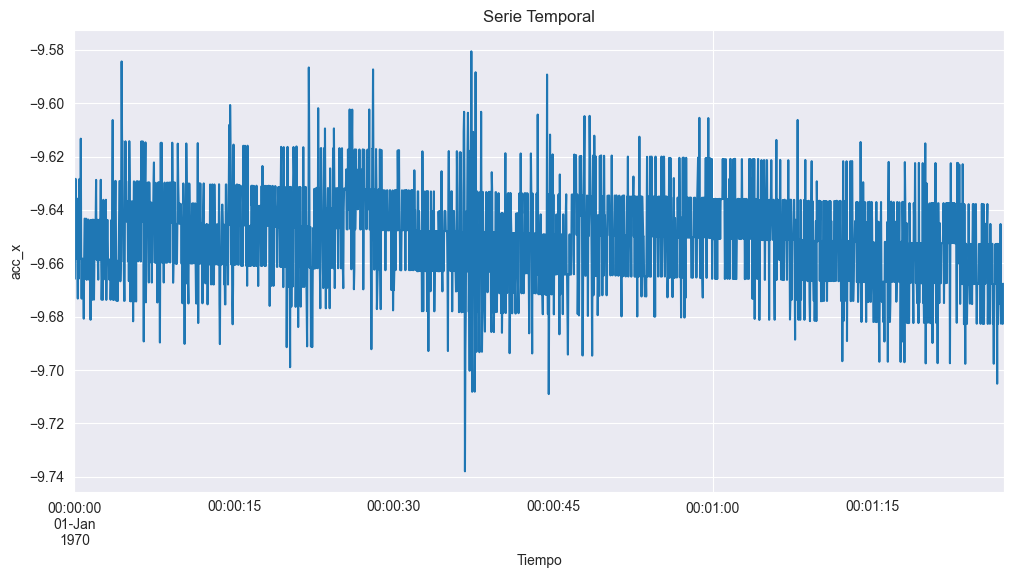

In [29]:
timeserie.plot(figsize=(12, 6))
plt.title('Serie Temporal')
plt.xlabel('Tiempo')
plt.ylabel(variable)
plt.show()

### Normalidad

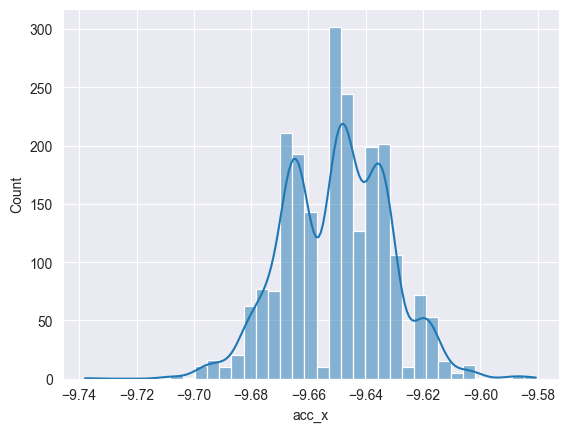

In [10]:
sns.histplot(timeserie, kde=True);

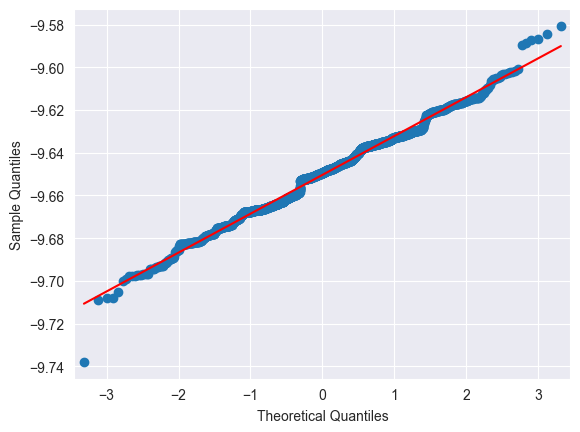

In [11]:
qqplot(timeserie, line='s');

In [30]:
from scipy import stats

print('Shapiro-Wilk Test:')
stat, p = stats.shapiro(timeserie)
print('Statistics=%.6f, p=%e' % (stat, p))

alpha = 0.05
if p > alpha:
 print('Sample looks Normal (fail to reject H0)')
else:
 print('Sample does not look Normal (reject H0)')

Shapiro-Wilk Test:
Statistics=0.991685, p=7.327696e-10
Sample does not look Normal (reject H0)


In [31]:

print('Kolmogorov-Smirnov:')
stat, p = stats.kstest(timeserie, stats.norm.cdf)
print('Statistics=%.6f, p=%e' % (stat, p))

alpha = 0.05
if p > alpha:
 print('Sample looks Normal (fail to reject H0)')
else:
 print('Sample does not look Normal (reject H0)')

Kolmogorov-Smirnov:
Statistics=1.000000, p=0.000000e+00
Sample does not look Normal (reject H0)


### Descomposición

#### Linealidad

In [14]:
from sklearn.linear_model import LinearRegression
import numpy as np


trend_model = LinearRegression(fit_intercept=True)
trend_model.fit(np.arange(data.shape[0]).reshape((-1,1)), timeserie)

LinearRegression()

<Axes: xlabel='Time'>

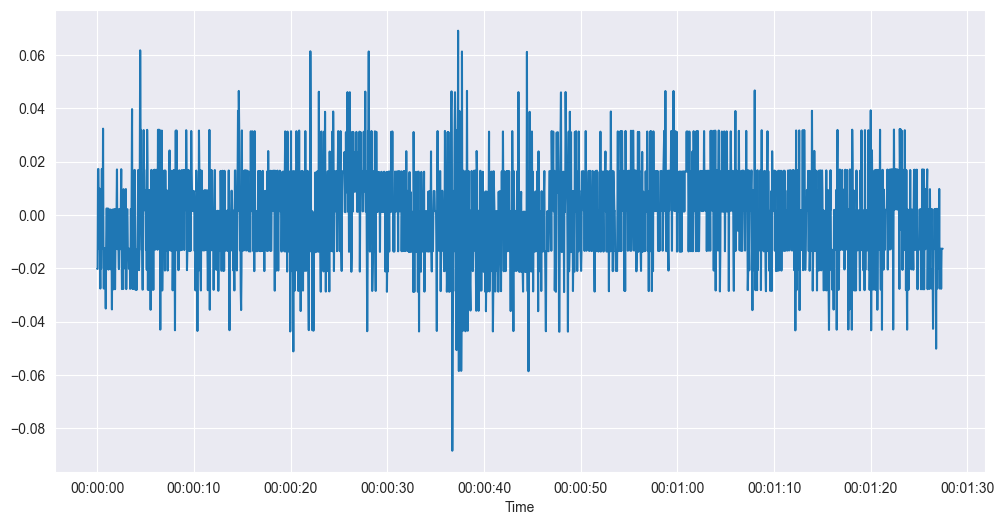

In [15]:
residuals = np.array(timeserie) - trend_model.predict(np.arange(data.shape[0]).reshape((-1,1)))

plt.figure(figsize=(12, 6))
sns.lineplot(y=residuals, x=data.index)

<Axes: xlabel='Time'>

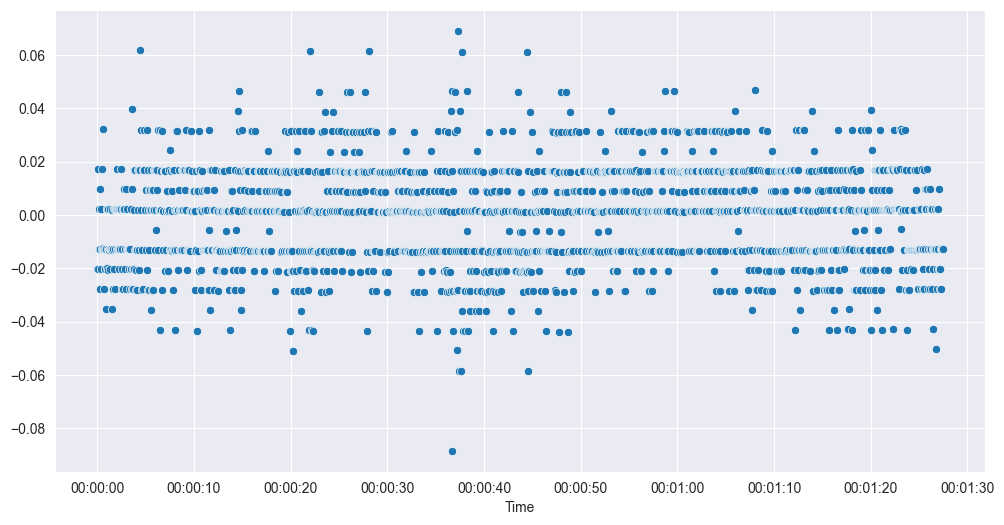

In [16]:
plt.figure(figsize=(12, 6))
sns.scatterplot(y=residuals, x=data.index)

#### Estacionalidad

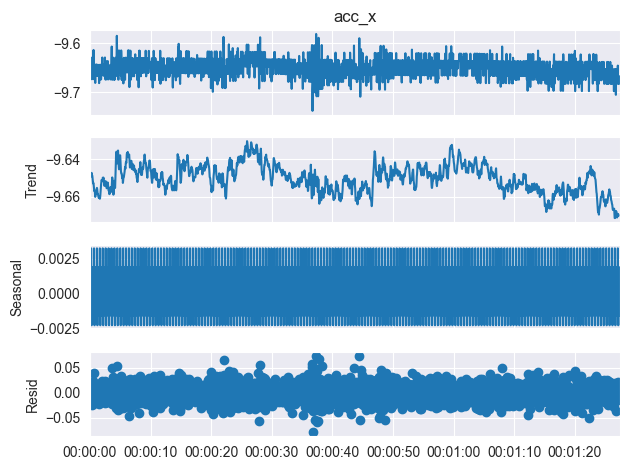

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(timeserie)
fig = decomposition.plot()
plt.show()

## Verificar estacionaridad

En esta sección se valida que nuestra serie de tiempo sea estacionaria

In [18]:
from statsmodels.graphics.tsaplots import plot_acf


In [34]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
    print("-----")
    alpha = 0.05

    if dfoutput["p-value"] <= alpha:
        print("Rechazamos la hipótesis nula y concluimos que la serie es estacionaria.")
    else:
        print("No podemos rechazar la hipótesis nula, Es decir la serie no es estacionaria.")


def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [35]:
adf_test(timeserie)

Results of Dickey-Fuller Test:
Test Statistic                   -4.042179
p-value                           0.001205
#Lags Used                       22.000000
Number of Observations Used    2164.000000
Critical Value (1%)              -3.433375
Critical Value (5%)              -2.862877
Critical Value (10%)             -2.567482
dtype: float64
-----
Rechazamos la hipótesis nula y concluimos que la serie es estacionaria.


Text(0.5, 1.0, 'PACF')

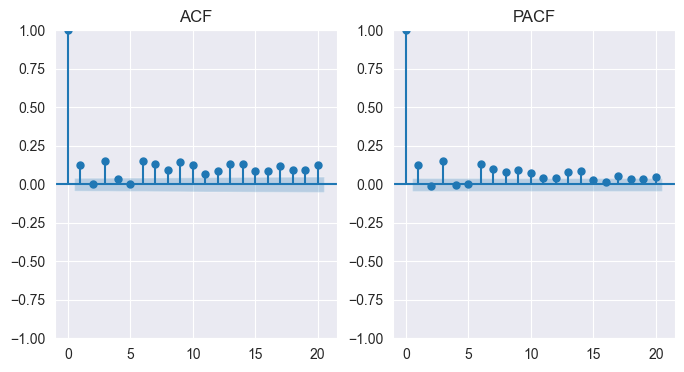

In [45]:
plt.figure(figsize=(8, 4))
plt.subplot(121)
plot_acf(timeserie, lags=20, ax=plt.gca())
plt.title('ACF')

plt.subplot(122)
plot_pacf(timeserie, lags=20, method='ywm', ax=plt.gca())
plt.title('PACF')

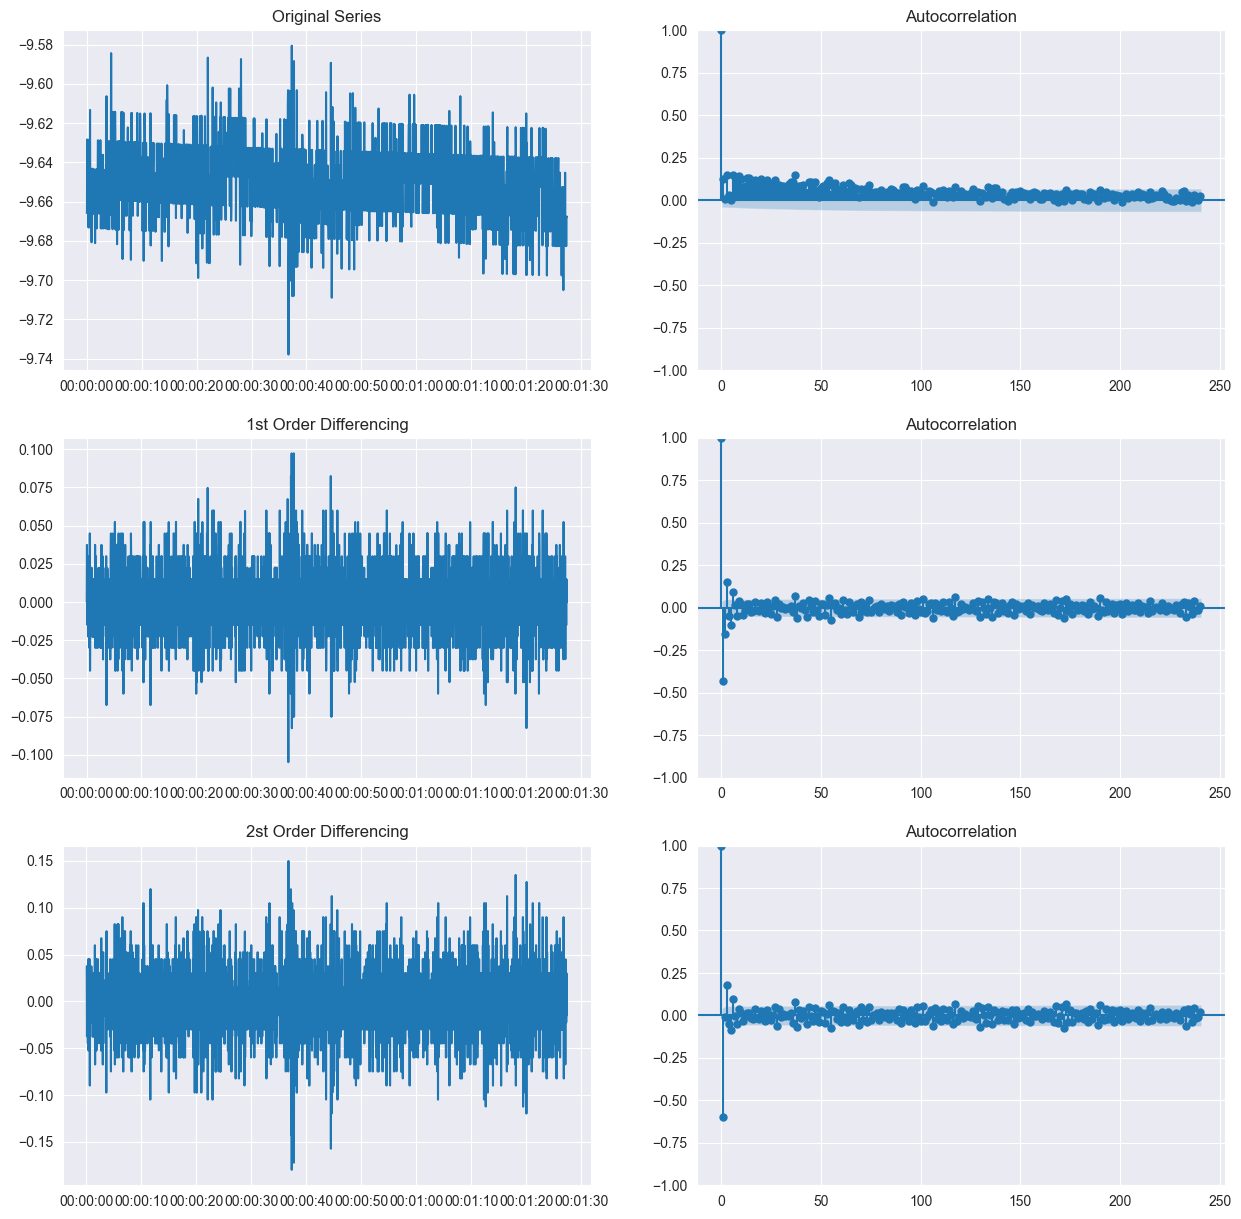

In [22]:
plt.rcParams.update({'figure.figsize': (15,15)})

fig, axes = plt.subplots(3, 2)

axes[0, 0].plot(timeserie); axes[0, 0].set_title('Original Series')
plot_acf(timeserie, ax=axes[0, 1], lags = 240);

axes[1, 0].plot(timeserie.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(timeserie.diff().dropna(), ax=axes[1, 1], lags = 240);

axes[2, 0].plot(timeserie.diff().diff()); axes[2, 0].set_title('2st Order Differencing')
plot_acf(timeserie.diff().diff().dropna(), ax=axes[2, 1], lags = 240);

## ARIMA
----

In [23]:
from statsmodels.tsa.arima.model import ARIMA

In [24]:
n_timeserie = len(timeserie); n_vald = 200 # set 
train_size = n_timeserie - n_vald

train = timeserie[:train_size]
dates_train = timeserie.index[:train_size]

vald = timeserie[train_size:train_size + n_vald] 
dates_vald = timeserie.index[train_size:train_size + n_vald] 
print("train:", train.shape)
print("test_4w:", dates_vald.shape)

train: (1987,)
test_4w: (200,)


In [25]:
frecuencia = pd.infer_freq(data.index)
print("Frecuencia: ", frecuencia)

Frecuencia:  40ms


In [49]:
best_aic = np.inf
best_bic = np.inf

best_order = None
best_mdl = None

pq_rng = range(5)
d_rng  = range(3)

for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                print(i, d, j)
                tmp_mdl = ARIMA(train, order=(i,d,j), freq=frecuencia).fit()
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue

0 0 0
0 0 1
0 0 2
0 0 3
0 0 4
0 1 0
0 1 1
0 1 2
0 1 3
0 1 4
0 2 0
0 2 1
0 2 2
0 2 3
0 2 4
1 0 0
1 0 1
1 0 2
1 0 3
1 0 4
1 1 0
1 1 1
1 1 2
1 1 3
1 1 4
1 2 0
1 2 1
1 2 2
1 2 3
1 2 4
2 0 0
2 0 1
2 0 2
2 0 3
2 0 4
2 1 0
2 1 1
2 1 2
2 1 3
2 1 4
2 2 0
2 2 1
2 2 2
2 2 3
2 2 4
3 0 0
3 0 1
3 0 2
3 0 3
3 0 4
3 1 0
3 1 1
3 1 2
3 1 3
3 1 4
3 2 0
3 2 1
3 2 2
3 2 3
3 2 4
4 0 0
4 0 1
4 0 2
4 0 3
4 0 4
4 1 0
4 1 1
4 1 2
4 1 3
4 1 4
4 2 0
4 2 1
4 2 2
4 2 3
4 2 4


In [54]:
print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic:    inf | order: (4, 2, 4)


In [55]:
from statsmodels.graphics.tsaplots import plot_predict

In [56]:
model = ARIMA(train, order=best_order)
model_fit = model.fit()

/home/sagemaker-user/.conda/envs/anomaly_py312/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 40ms will be used.
  self._init_dates(dates, freq)
/home/sagemaker-user/.conda/envs/anomaly_py312/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 40ms will be used.
  self._init_dates(dates, freq)
/home/sagemaker-user/.conda/envs/anomaly_py312/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 40ms will be used.
  self._init_dates(dates, freq)
/home/sagemaker-user/.conda/envs/anomaly_py312/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/sage

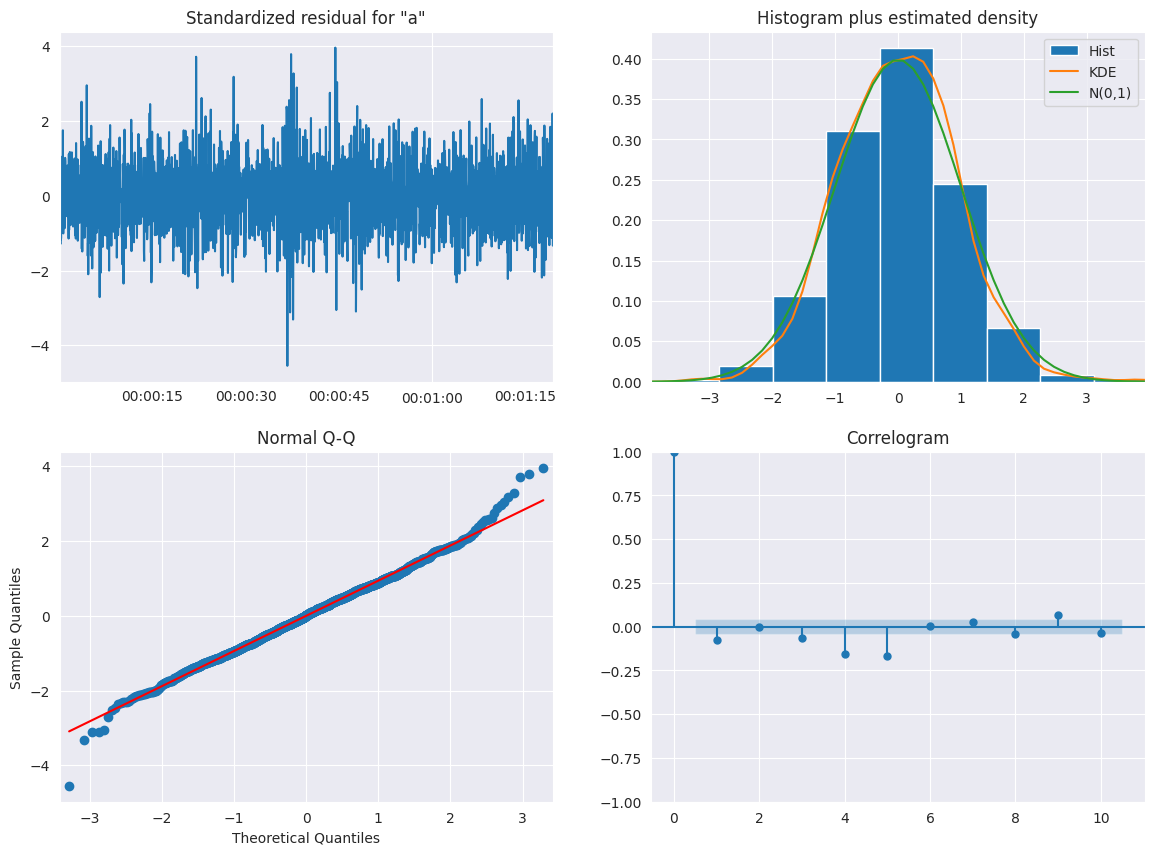

In [57]:
model_fit.plot_diagnostics(figsize=(14,10));

### Validación